In [1]:
import time
import os
import sys
import csv
import json
import shutil
import random
import pprint
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

sys.path.insert(1, 'HelperScripts')
from HelperFunctions import *
from pytorch_resnet import *
from randaugment import RandAugmentMC

os.environ["WANDB_SILENT"] = "true"
import wandb
#%env "WANDB_NOTEBOOK_NAME" "Baseline Training"

import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

In [2]:
device_name = torch.cuda.get_device_name(0)
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

transform_test = transforms.Compose([
            #transforms.Resize((image_size,image_size), max_size=None, antialias=None),
            transforms.ToTensor()
])

Number of testing examples: 446
{'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
[0, 1, 2, 3, 4]


C:\Users\zarre\.conda\envs\gpu\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
C:\Users\zarre\.conda\envs\gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


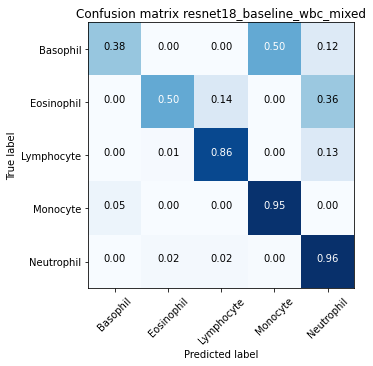

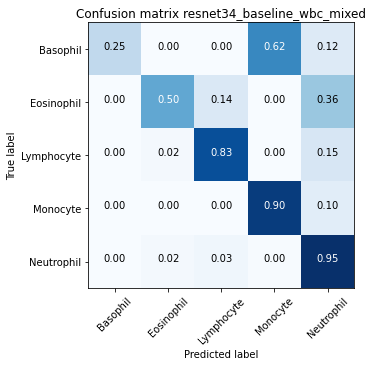

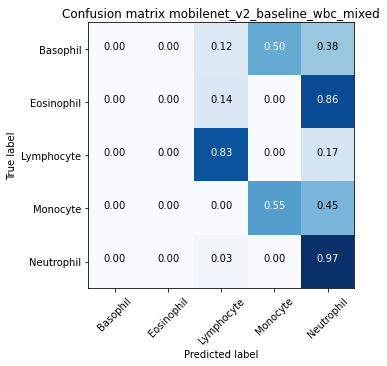

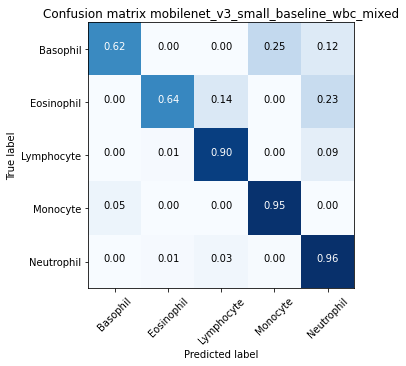

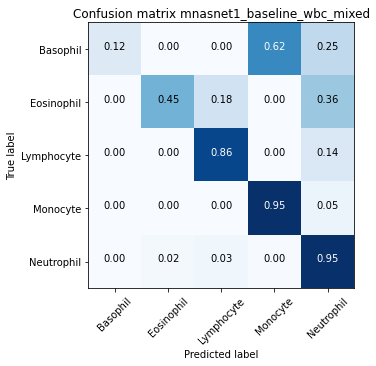

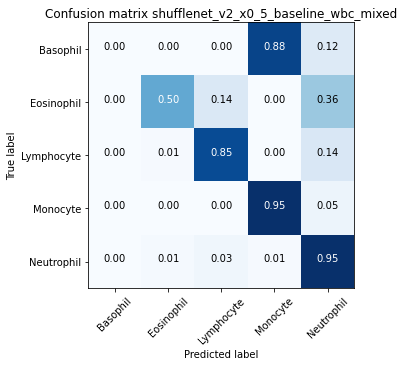

In [3]:
for colour in ['mixed']:
#'green','red','purple','fluor'
    config_test = dict(
        classes=['Basophil','Eosinophil','Lymphocyte','Monocyte','Neutrophil'],
        image_size=250,
        batch_size=4,
        batch_size_latency=1,
        save = 'Models/baseline/'+colour+'/',
        save_suffix = "_baseline_wbc_"+colour,
        test_set = 'purple_test',
        architecture_list = ['resnet18', 'resnet34', 'mobilenet_v2', 'mobilenet_v3_small', 'mnasnet1', 'shufflenet_v2_x0_5']
    )
    test_data = datasets.ImageFolder("Data/WBC_Classification_split/" + config_test['test_set'] + "/test", transform=transform_test)
    print(f'Number of testing examples: {len(test_data)}')
    valid_loader = dataloader(test_data, batch_size=config_test['batch_size'], pin_memory=True, drop_last=True)
    print(test_data.class_to_idx)
    torch.unique(torch.FloatTensor(test_data.targets), return_counts=True)
    print(list(test_data.class_to_idx.values()))
    for architecture in config_test['architecture_list']:
        with wandb.init(project="Baseline Training", config=config_test, group="Testing", tags=[colour,'Testing',config_test['test_set']], job_type='eval', reinit=True):
            wandb.config['architecture'] = architecture
            wandb.run.summary['architecture'] = architecture
            wandb.config['colour'] = colour
            config = wandb.config
            wandb.run.name = config['architecture']+config['save_suffix']
            model = create_model(architecture, cuda_device)
            model_name = config['architecture']+config['save_suffix'] + ".pt"
            check_point = torch.load(config['save']+model_name)
            model.load_state_dict(check_point['model_state_dict'])
            model.eval()
            #Model size
            wandb.run.summary['Model Size'] = size_measure(model)
            #Measure Accuracy
            loss_fn = nn.CrossEntropyLoss().to(cuda_device)
            results, acc, cm = evaluate2(model=model, device=cuda_device, loader=valid_loader, batch_size=config['batch_size'], loss_fun=loss_fn, labels_indx=list(test_data.class_to_idx.values()), names=list(test_data.class_to_idx.keys()))
            # sample_weight=torch.unique(torch.FloatTensor(test_data.targets),return_counts=True)[1].tolist()
            #pprint.pprint(results)
            wandb.run.summary['Accuracy'] = acc
            wandb.run.summary['CM'] = cm
            wandb.run.summary['CM Plot'] = wandb.Image(return_cm(cm, config['classes'], normalize=True, title='Confusion matrix '+ config['architecture'] + config['save_suffix'], cmap=plt.cm.Blues))
            wandb.run.summary['Results'] = results
            #Measure Latency
            time_logger, std_logger, time2_logger = latency_test(model, cpu_device, repetitions=300, batch_size=config['batch_size_latency'], num_threads=0)
            wandb.run.summary['Inference Time'] = {'CUDA':time_logger,'Std':std_logger,'CPU':time2_logger}
            wandb.run.summary['Acc/Time'] = acc/time_logger
            wandb.run.summary['Macro F1/Time'] = results['macro avg']['f1-score']/time_logger
            #print_measurements(config['classes'],precision,sensitivity,f1,acc,cm,wandb.run.summary['Model Size'],time_logger,time2_logger)
            #clear_output(wait=True)